# PRACTICA ANITSPOOFING IAA

In [199]:
import pandas as pd
import numpy as np

from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import  ConfusionMatrixDisplay,\
                  classification_report,  RocCurveDisplay, PrecisionRecallDisplay,\
                    accuracy_score, f1_score, precision_score, recall_score

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

from time import time
from datetime import timedelta
init_time = time()
np.random.seed(42)
import warnings
warnings.filterwarnings("ignore")

# Importem els csv

In [200]:
df_train = pd.read_csv('./training_set.csv')
df_test = pd.read_csv('./test_set.csv')
df_smile = pd.read_csv('./smile_feature_selected.csv')
df_categoriques = pd.read_csv('./full_habla_updated_metadata.csv')

Visualitzem les variables numèriques i canviem els seus noms per treballar amb elles més fàcilment

In [201]:
df_smile.rename(columns={
    'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope': 'Semitone_Rising',
    'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope': 'Semitone_Mean',
    'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope.1': 'Semitone_Mean_1',
    'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope': 'Semitone_Falling',
    'loudness_sma3_amean': 'Loudness_Mean',
    'spectralFlux_sma3_stddevNorm': 'SpectralFlux',
    'mfcc1_sma3_amean': 'mfcc1_mean',
    'mfcc1_sma3_stddevNorm': 'mfcc1_stddev',
    'mfcc2_sma3_amean': 'mfcc2_mean',
    'mfcc2_sma3_stddevNorm': 'mfcc2_stddev',
    'mfcc3_sma3_amean': 'mfcc3_mean',
    'mfcc3_sma3_stddevNorm': 'mfcc3_stddev',
    'jitterLocal_sma3nz_amean': 'Jitter_Mean',
    'slopeUV500-1500_sma3nz_amean': 'Slope_Mean'
}, inplace=True)

display(df_smile.head())
df_smile.drop(['Unnamed: 0'], axis=1, inplace=True) # Eliminem la variable identificadora del numero de fila

,Unnamed: 0,Semitone_Rising,Semitone_Mean,Semitone_Mean_1,Semitone_Falling,Loudness_Mean,SpectralFlux,mfcc1_mean,mfcc1_stddev,mfcc2_mean,mfcc2_stddev,mfcc3_mean,mfcc3_stddev,Jitter_Mean,Slope_Mean,UniqueID
0,0,13.655039,31.285376,31.285376,16.190195,0.338007,1.871209,19.641603,0.671554,12.977986,1.174820,15.133403,1.055712,0.024725,0.013012,12887
1,1,33.807160,42.137940,42.137940,22.348753,0.481519,1.837113,19.642485,0.632724,7.225969,2.289886,14.791618,1.183340,0.020789,0.009675,16019
2,2,16.206518,26.210506,26.210506,12.744358,0.268581,1.936138,23.789776,0.523593,12.097356,1.287826,10.082766,1.598042,0.012824,0.013230,19916
3,3,74.068300,39.873170,39.873170,20.845293,0.169376,1.752427,19.072332,0.680972,11.948067,1.284195,14.839839,1.081400,0.024667,0.022918,35287
4,4,14.972388,22.553352,22.553352,11.603700,0.313857,1.848405,21.528349,0.616796,10.465217,1.392769,17.536242,0.903966,0.014983,0.016212,3608


Visualitzem les variables categòriques, comprovem que les úniques variables categòriques que s'hi poden extreure són Sex, Country i Utterance, les quals haurem de preprocessar.

En el cas de Utterance, es correspon amb un identificador de la transcripció de l'àudio, de manera que en certa manera és un id i aportaria informació determinista al model de manera que decidim eliminar-la.

Pel cas de les altres dues variables només hem d'ajuntar dues variables ('Sex' i 'Target_Sex', 'Country' i 'Target_Country')

In [202]:
#display(df_categoriques.head())
df_categoriques['Sex'] = df_categoriques['Sex'].fillna(df_categoriques['Target_Sex'])
df_categoriques['Country'] = df_categoriques['Country'].fillna(df_categoriques['Target_Country'])
df_cat = df_categoriques[['UniqueID','Sex','Country']]
display(df_cat.head())

,UniqueID,Sex,Country
0,12887,Female,Argentina
1,16019,Female,Argentina
2,19916,Female,Argentina
3,35287,Female,Argentina
4,3608,Male,Argentina


Ajuntem els dos datasets i podem fer la partició train/test

In [203]:
df_joined = df_smile.merge(df_cat, on='UniqueID', how='inner')
display(df_joined.head())
df_unique_train = df_train[['UniqueID','Realornot']]
df_unique_test = df_test[['UniqueID','Realornot']]
train = df_unique_train.merge(df_joined, on='UniqueID', how='inner')
test = df_unique_test.merge(df_joined, on='UniqueID', how='inner')

,Semitone_Rising,Semitone_Mean,Semitone_Mean_1,Semitone_Falling,Loudness_Mean,SpectralFlux,mfcc1_mean,mfcc1_stddev,mfcc2_mean,mfcc2_stddev,mfcc3_mean,mfcc3_stddev,Jitter_Mean,Slope_Mean,UniqueID,Sex,Country
0,13.655039,31.285376,31.285376,16.190195,0.338007,1.871209,19.641603,0.671554,12.977986,1.174820,15.133403,1.055712,0.024725,0.013012,12887,Female,Argentina
1,33.807160,42.137940,42.137940,22.348753,0.481519,1.837113,19.642485,0.632724,7.225969,2.289886,14.791618,1.183340,0.020789,0.009675,16019,Female,Argentina
2,16.206518,26.210506,26.210506,12.744358,0.268581,1.936138,23.789776,0.523593,12.097356,1.287826,10.082766,1.598042,0.012824,0.013230,19916,Female,Argentina
3,74.068300,39.873170,39.873170,20.845293,0.169376,1.752427,19.072332,0.680972,11.948067,1.284195,14.839839,1.081400,0.024667,0.022918,35287,Female,Argentina
4,14.972388,22.553352,22.553352,11.603700,0.313857,1.848405,21.528349,0.616796,10.465217,1.392769,17.536242,0.903966,0.014983,0.016212,3608,Male,Argentina


Mirem les distribucions de les variables contínues dintre el train per veure com preprocessar-les

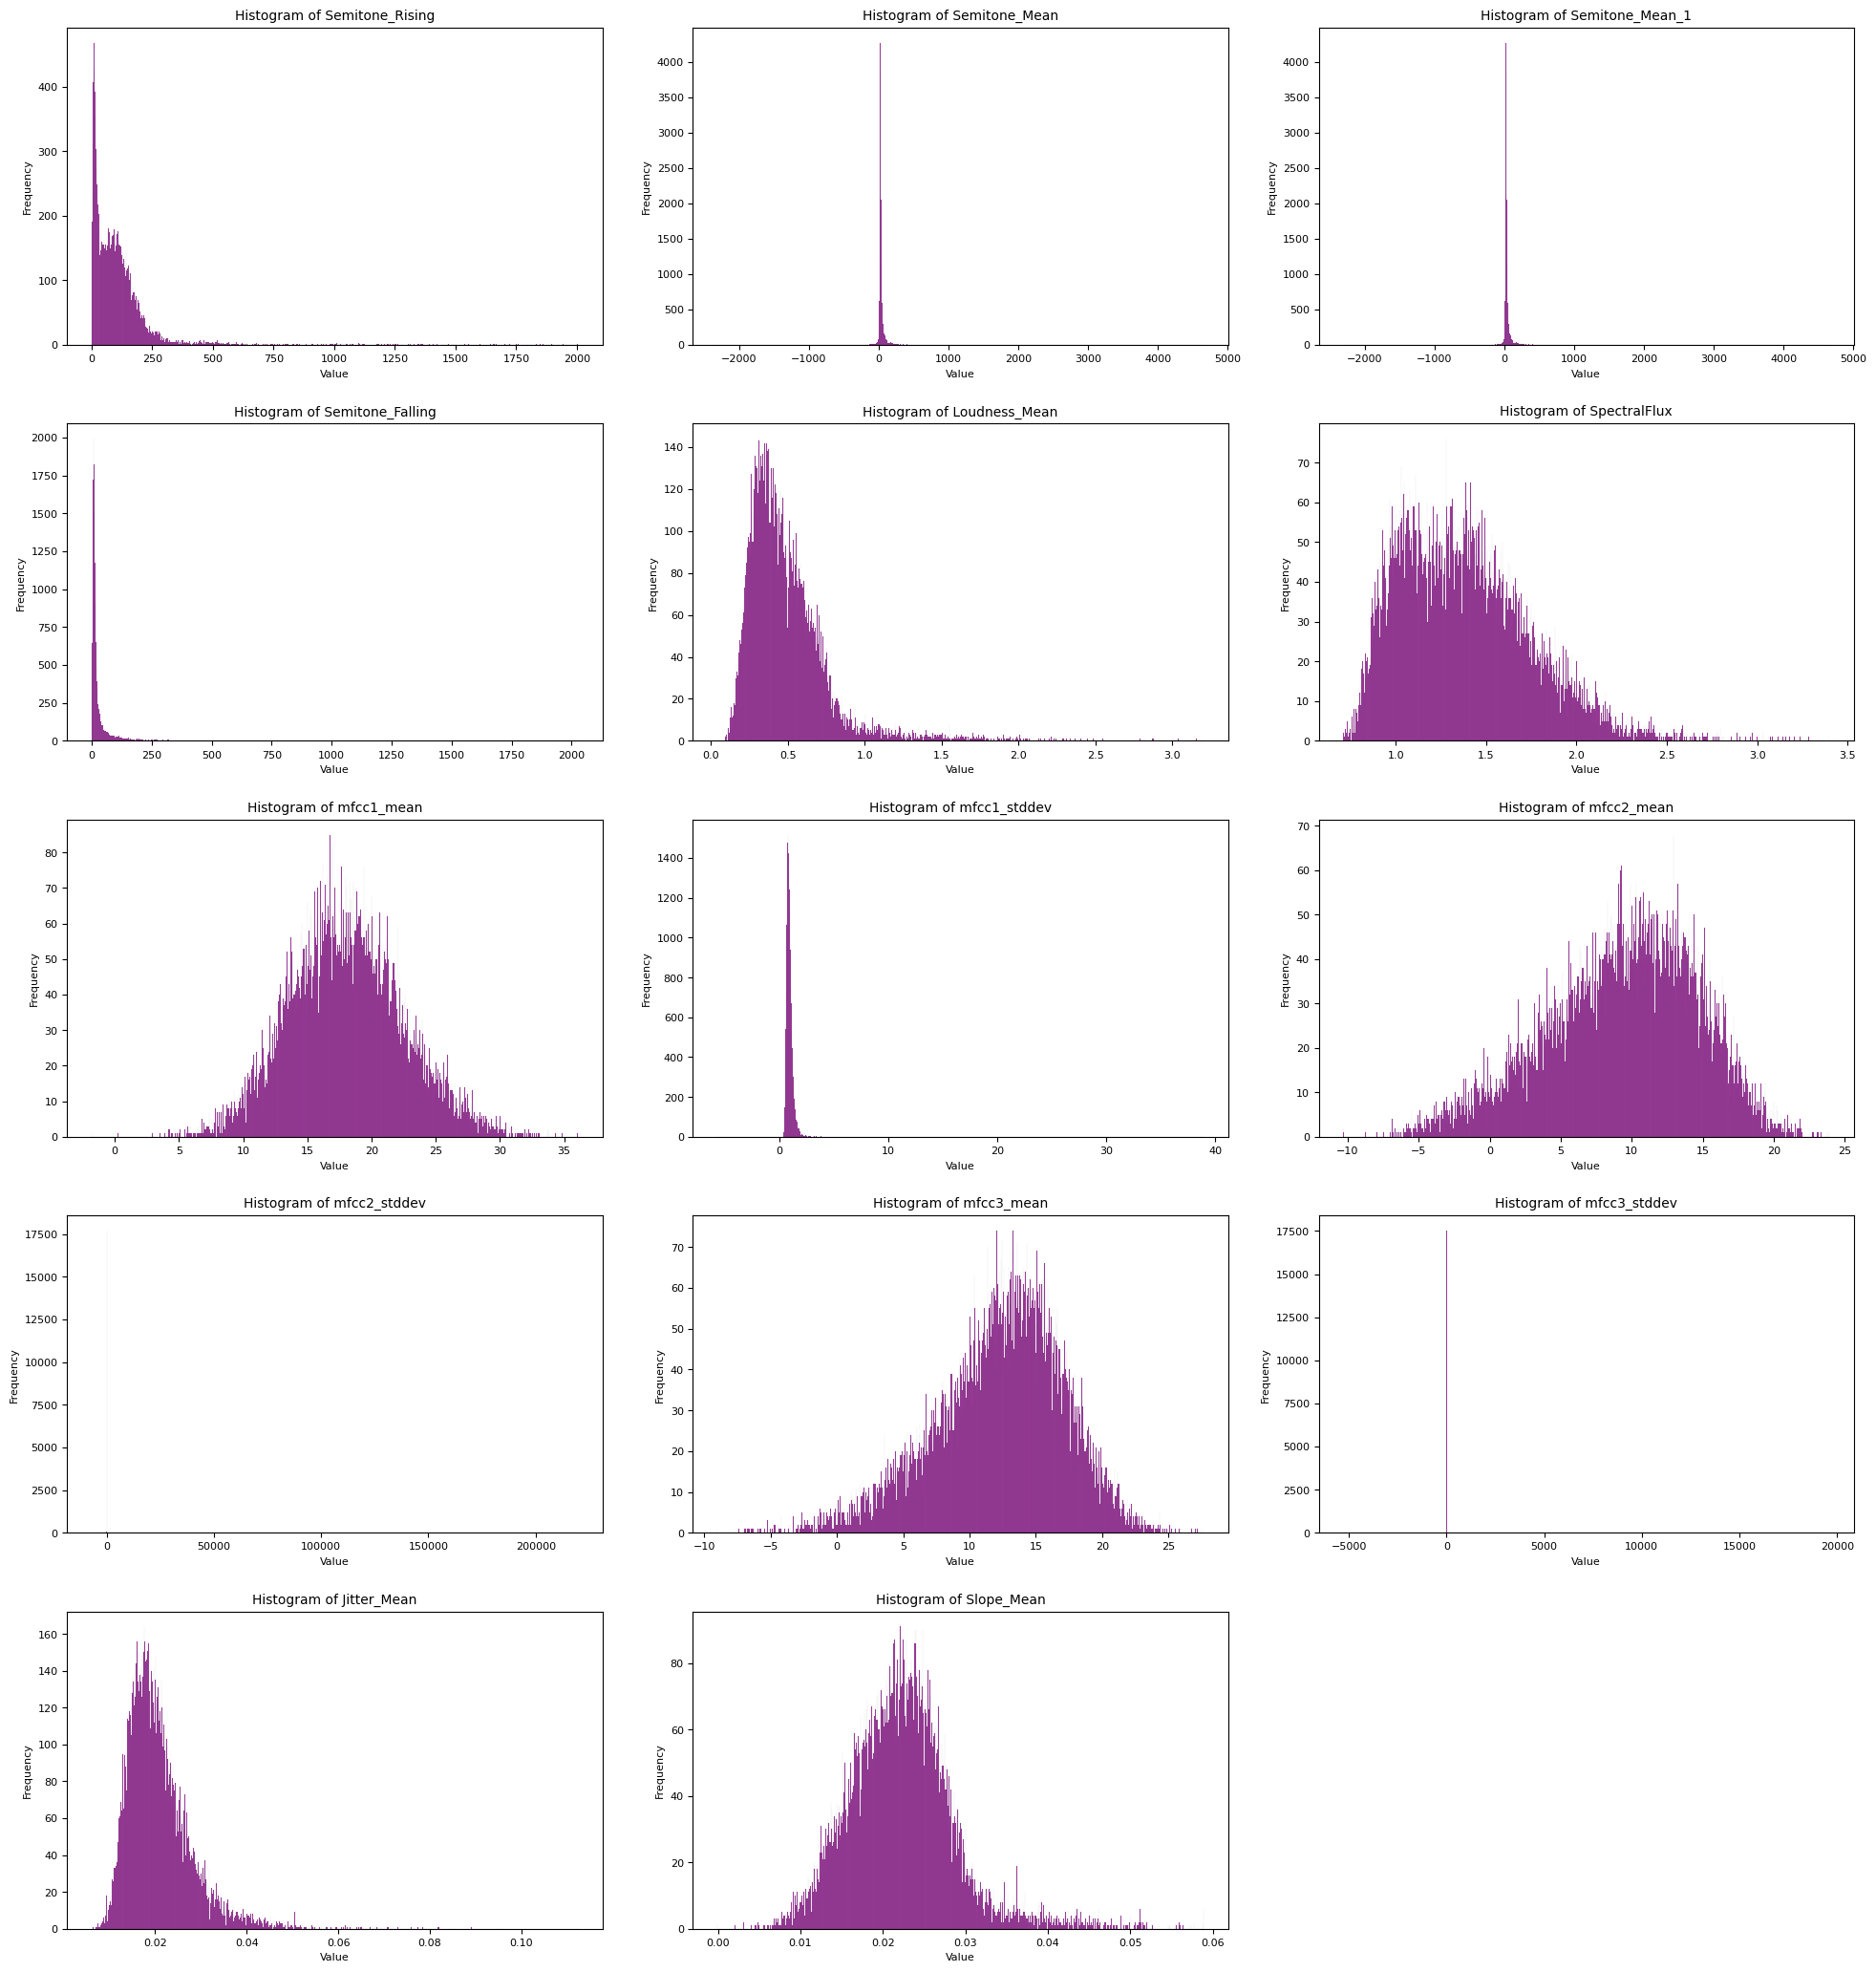

In [204]:
import seaborn as sns
import matplotlib.pyplot as plt

train_numeriques = train.drop(['UniqueID', 'Country', 'Sex','Realornot'], axis=1)

def plot_histograms(dataframe):
    num_columns = len(dataframe.columns)
    fig, axes = plt.subplots(nrows=num_columns // 3 + (num_columns % 3 > 0), ncols=3, figsize=(20, num_columns * 1.5))

    for i, ax in enumerate(axes.flatten()):
        if i < num_columns:
            selected_column = dataframe.iloc[:, i]
            sns.histplot(selected_column, bins=1000, edgecolor='black', color='purple', binrange=(min(selected_column), max(selected_column)), ax=ax)
            ax.set_title(f'Histogram of {selected_column.name}', fontsize=10)
            ax.set_xlabel('Value', fontsize=8)
            ax.set_ylabel('Frequency', fontsize=8)
            ax.tick_params(axis='both', which='major', labelsize=8)
        else:
            fig.delaxes(ax)

plot_histograms(train_numeriques)
plt.tight_layout(pad=2.0)
plt.show();


### Balanceig de la variable objectiu
Veiem que Realornot ja està balancejada

Distribució de classes en el conjunt d'entrenament:
Realornot
1    8939
0    8865
Name: count, dtype: int64

Distribució de classes en el conjunt de test:
Realornot
1    1200
0    1172
Name: count, dtype: int64
Les classes estan equilibrades en el conjunt d'entrenament


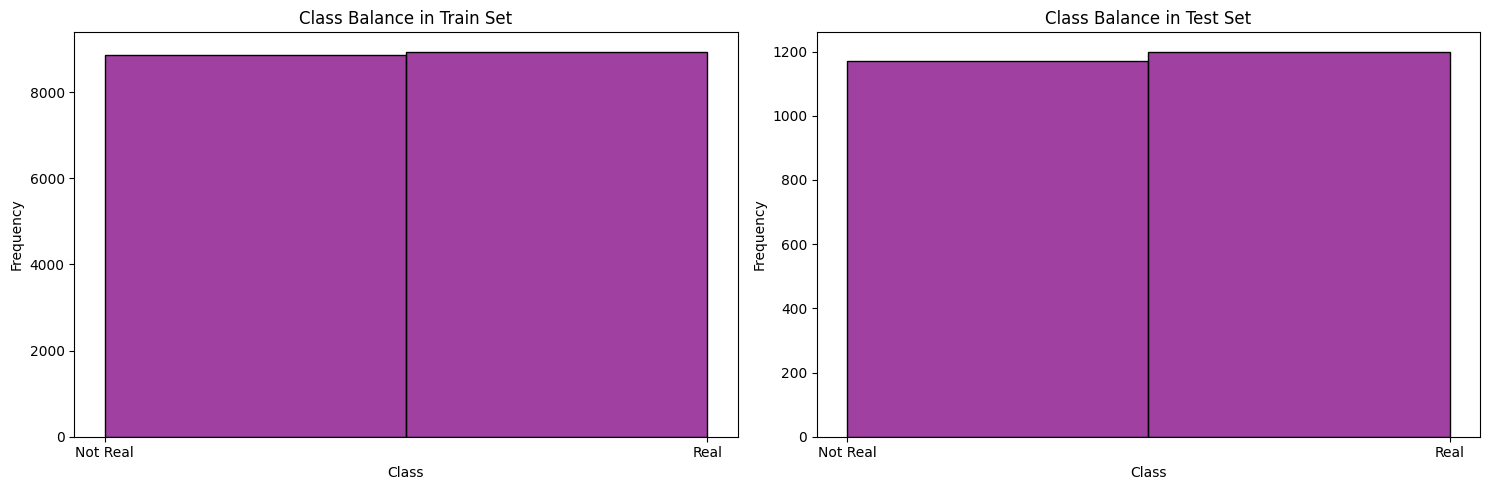

In [205]:
train_class_counts = train['Realornot'].value_counts()
test_class_counts = test['Realornot'].value_counts()

print("Distribució de classes en el conjunt d'entrenament:")
print(train_class_counts)
print("\nDistribució de classes en el conjunt de test:")
print(test_class_counts)

if abs(train_class_counts[0] - train_class_counts[1]) / len(train) > 0.1:
    print("Les classes estan desequilibrades en el conjunt d'entrenament")
else:
    print("Les classes estan equilibrades en el conjunt d'entrenament")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

sns.histplot(train['Realornot'], bins=2, kde=False, ax=axes[0], color='purple')
axes[0].set_title("Class Balance in Train Set")
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Frequency')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Not Real', 'Real'])

sns.histplot(test['Realornot'], bins=2, kde=False, ax=axes[1], color='purple')
axes[1].set_title("Class Balance in Test Set")
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Frequency')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Not Real', 'Real'])

plt.tight_layout();
plt.show();



Comprovem que les variables numèriques no contenen valors nuls, tot i això volem assegurar-nos que no contenen tampoc missings en forma de zeros, així que imprimim les distribucions de les variables que en contenen per analitzar-ho.

Com que les distribucions no es veien gaire bé degut als valors distants, imprimim els histogrames treient quartils per veure la naturalesa dels missings.

No hi ha missing values (NaN)


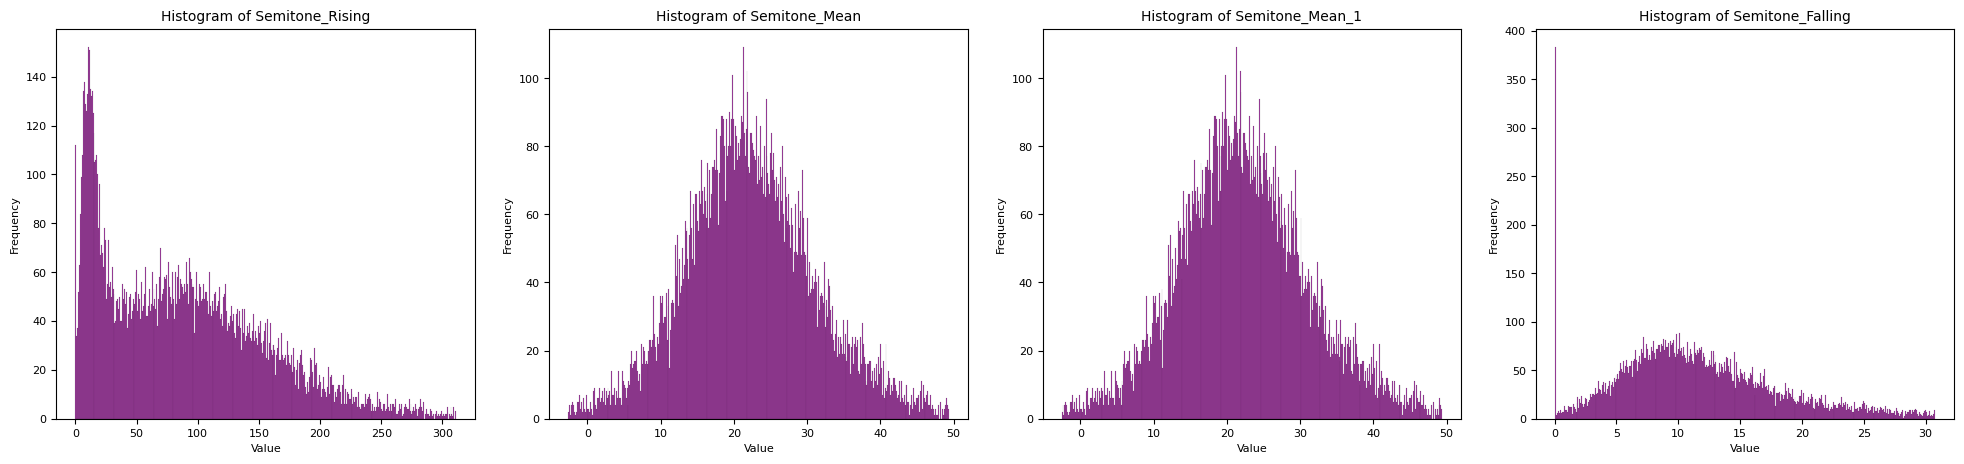

Semitone_Rising     148
Semitone_Mean         1
Semitone_Mean_1       1
Semitone_Falling    455
dtype: int64


In [206]:
if train_numeriques.isna().sum().any():
    print('Hi ha missing values (NaN)')
else:
    print('No hi ha missing values (NaN)')

def remove_outliers(df):
    df_clean = df.copy()
    for column in df_clean.columns:
        Q1 = df_clean[column].quantile(0.25)
        Q3 = df_clean[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[column] >= lower_bound) & (df_clean[column] <= upper_bound)]
    return df_clean

    # Crear un DataFrame con las 4 primeras variables de train_numeriques
df_possibles_missings = train_numeriques.iloc[:, :4]
df_possibles_missings = remove_outliers(df_possibles_missings)

# Visualización de los datos sin outliers
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

for i, ax in enumerate(axes.flatten()):
    selected_column = df_possibles_missings.iloc[:, i]
    sns.histplot(selected_column, bins=400, edgecolor='black', color='purple', binrange=(min(selected_column), max(selected_column)), ax=ax)
    ax.set_title(f'Histogram of {selected_column.name}', fontsize=10)
    ax.set_xlabel('Value', fontsize=8)
    ax.set_ylabel('Frequency', fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=8)

plt.tight_layout(pad=2.0)
plt.show()

print((train_numeriques.iloc[:, :4] == 0).sum());

Podem comprovar amb els histogrames anteriors que tant la primera variable (Semitone_Rising) com la 4a (Semitone_Falling), presenten missings amb el valor 0, de manera que haurem d'imputar-los.

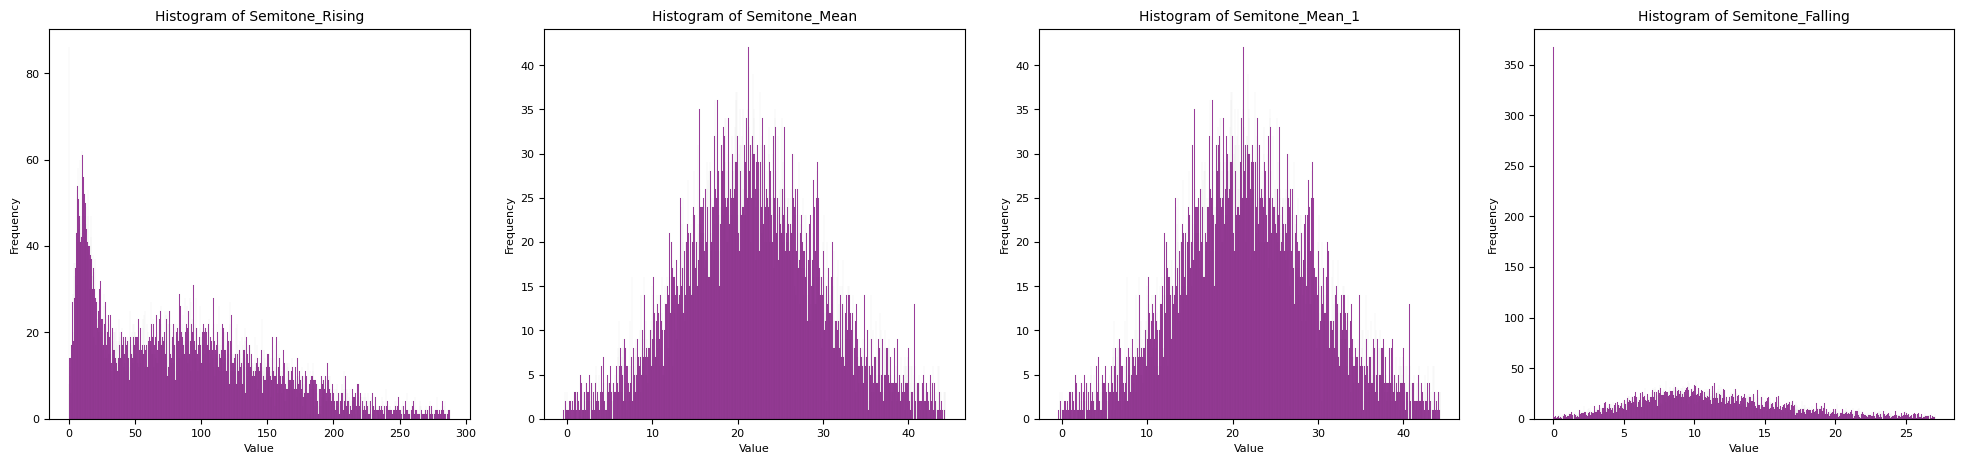

In [207]:
from sklearn.impute import KNNImputer

columns_to_impute = ['Semitone_Rising', 'Semitone_Falling']
train_numeriques[columns_to_impute] = train_numeriques[columns_to_impute].replace(0, np.nan)

knn_imputer = KNNImputer(n_neighbors=5)
train_numeriques[columns_to_impute] = knn_imputer.fit_transform(train_numeriques[columns_to_impute])

df_possibles_missin = train_numeriques.iloc[:, :4]
df_possibles_missin = remove_outliers(df_possibles_missings)

# Visualización de los datos sin outliers
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

for i, ax in enumerate(axes.flatten()):
    selected_column = df_possibles_missin.iloc[:, i]
    sns.histplot(selected_column, bins=1000, edgecolor='black', color='purple', binrange=(min(selected_column), max(selected_column)), ax=ax)
    ax.set_title(f'Histogram of {selected_column.name}', fontsize=10)
    ax.set_xlabel('Value', fontsize=8)
    ax.set_ylabel('Frequency', fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=8)

plt.tight_layout(pad=2.0)
plt.show();

Veiem que hem pogut imputar els missings correctament amb knn, de manera que també ho haurem de fer amb el conjunt de test

In [208]:
test_numeriques = test.drop(['UniqueID', 'Country', 'Sex','Realornot'], axis=1)

test_numeriques[columns_to_impute] = test_numeriques[columns_to_impute].replace(0, np.nan)

test_numeriques[columns_to_impute] = knn_imputer.transform(test_numeriques[columns_to_impute])

## Imputació d'outliers

In [209]:
import numpy as np
from sklearn.impute import KNNImputer

train_outlier = train_numeriques.copy()
test_outlier = test_numeriques.copy()

def imputar_outliers_knn(df, df2):
    for col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df.loc[(df[col] < lower_bound) | (df[col] > upper_bound), col] = np.nan
        df2.loc[(df2[col] < lower_bound) | (df2[col] > upper_bound), col] = np.nan

    return df, df2

train_outlier, test_outlier = imputar_outliers_knn(train_outlier, test_outlier)


Un cop marcats els outliers els imputem amb knn

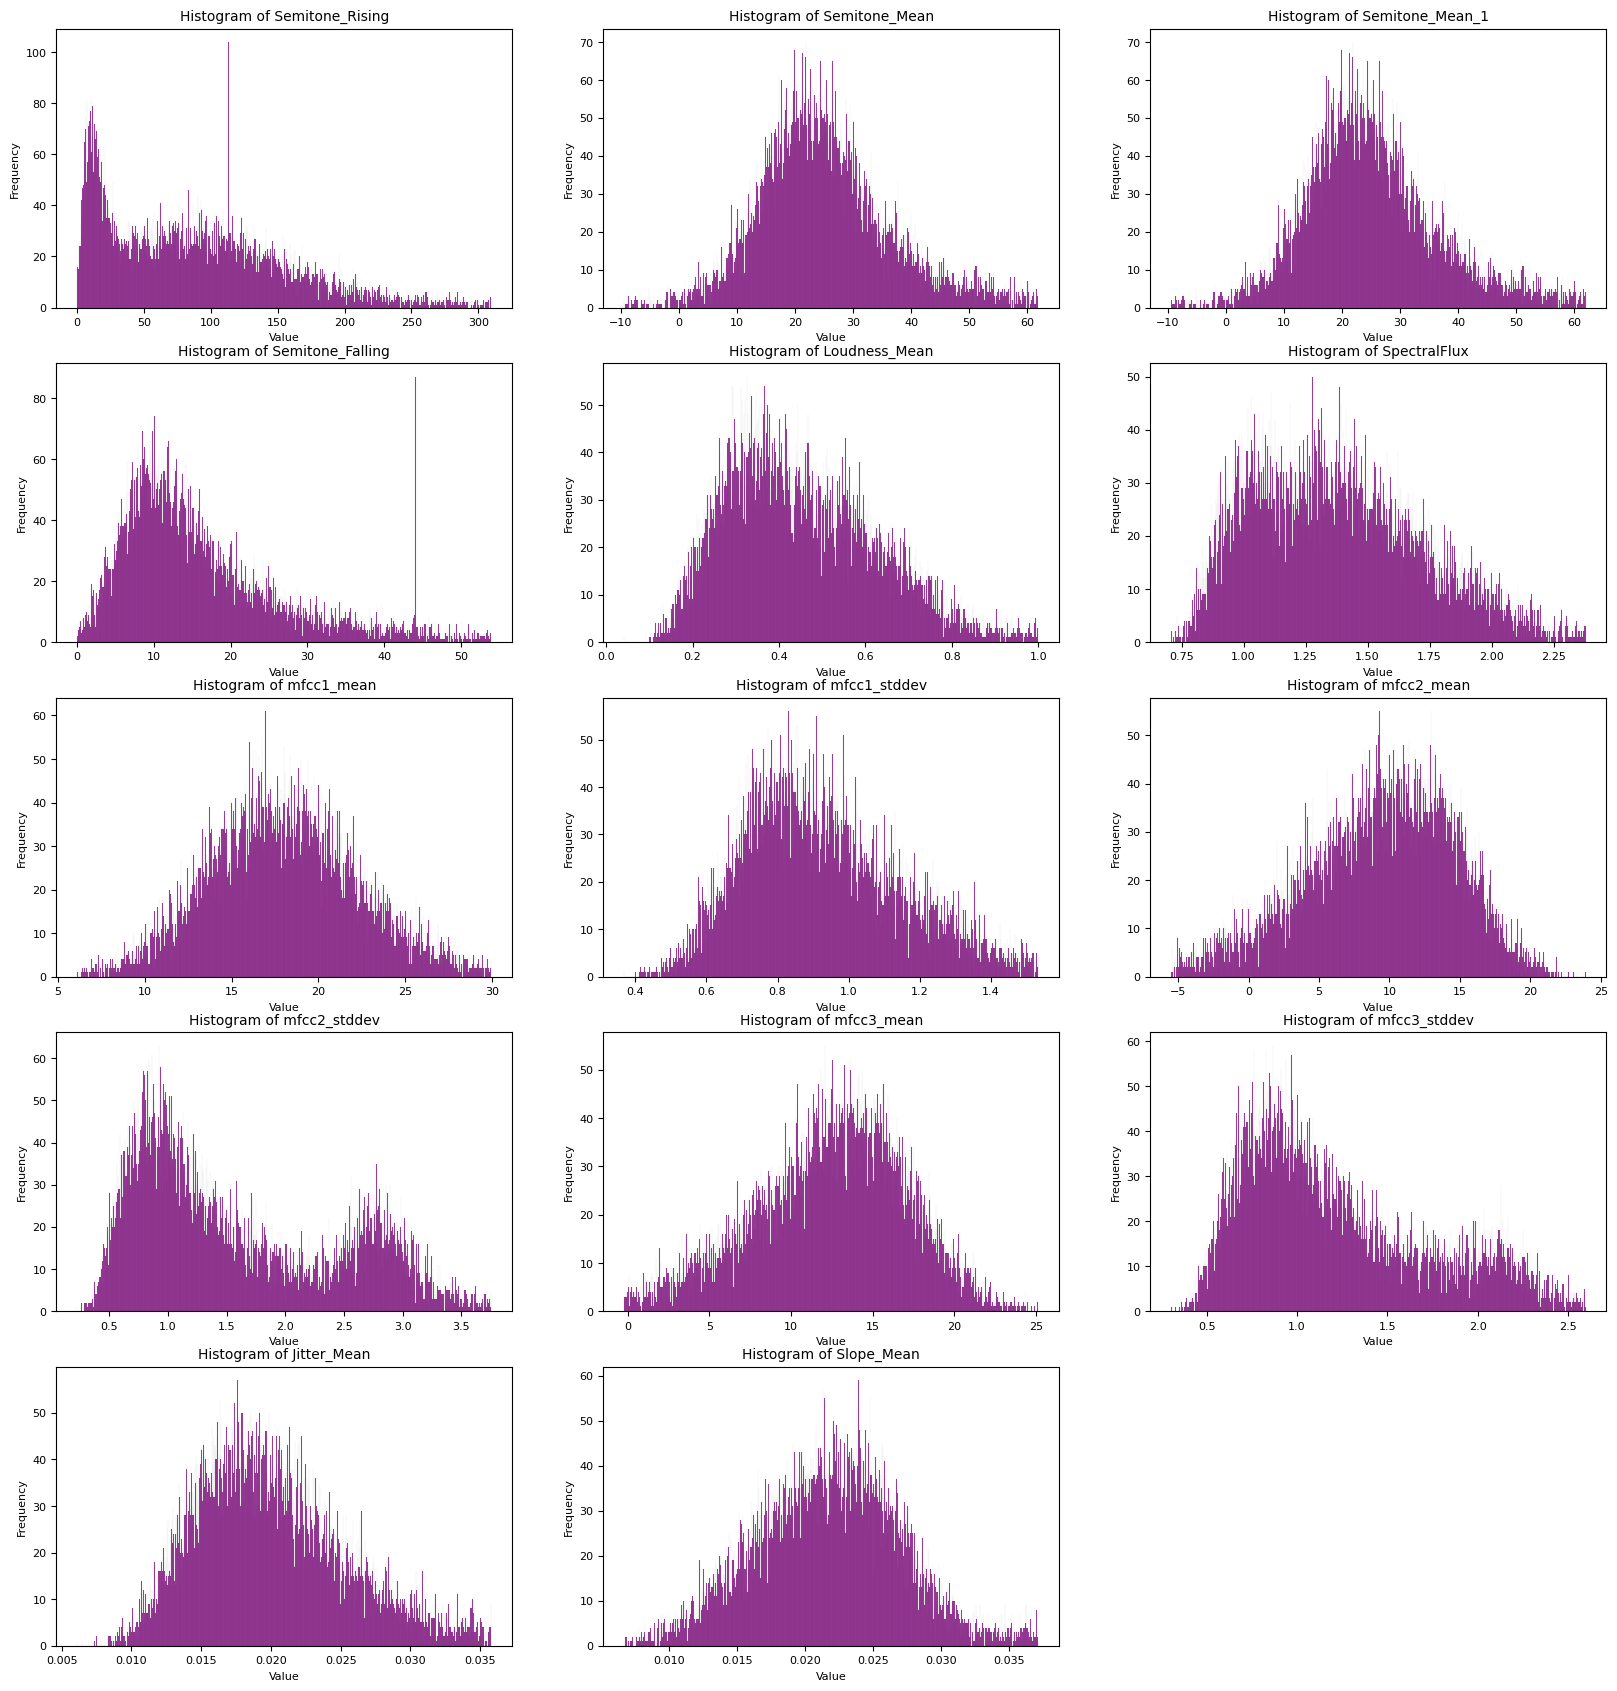

In [210]:
imputer = KNNImputer(n_neighbors=5)
train_outlier = pd.DataFrame(imputer.fit_transform(train_outlier), columns=train_numeriques.columns)
test_outlier = pd.DataFrame(imputer.transform(test_outlier), columns=test_numeriques.columns)

plot_histograms(train_outlier)

Després d'imputar les dades les hem d'escalar i normalitzar, de manera que apliquem una transformació logarítmica a les variables amb una distribució log-normal i després les estandaritzem amb l'StandardScaler

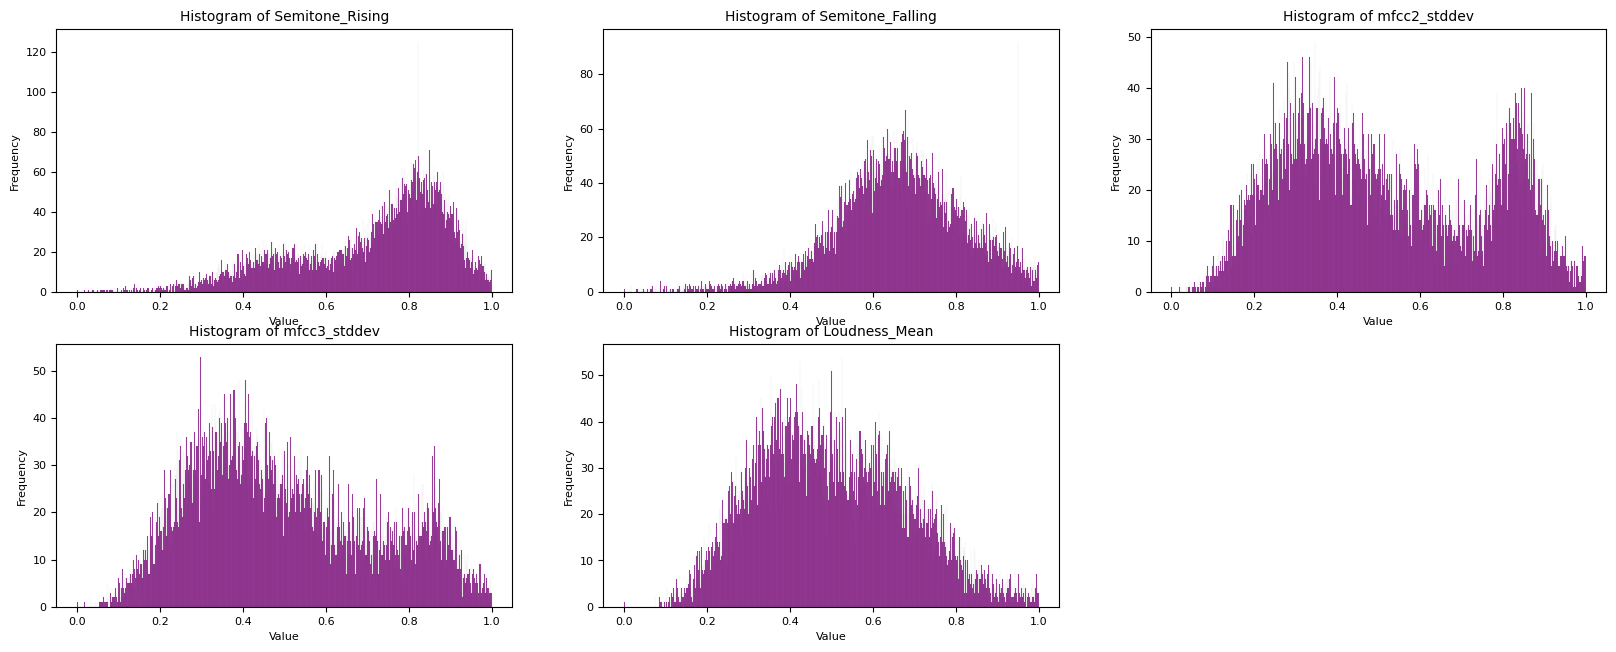

In [211]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()

gamma_col = ['Semitone_Rising','Semitone_Falling', 'mfcc2_stddev','mfcc3_stddev', 'Loudness_Mean']

train_outlier[gamma_col] = np.log1p(train_outlier[gamma_col])
test_outlier[gamma_col] = np.log1p(test_outlier[gamma_col])

train_scaled_outlier = pd.DataFrame(scaler.fit_transform(train_outlier), columns=train_outlier.columns)
test_scaled_outlier = pd.DataFrame(scaler.transform(test_outlier), columns=test_outlier.columns)

plot_histograms(train_scaled_outlier[gamma_col])

Un cop escalades les variables contínues, les podem ajuntar amb UniqueID i Realornot

In [212]:
train_preprocessed = train.copy()
test_preprocessed = test.copy()

train_preprocessed[train_scaled_outlier.columns] = train_scaled_outlier.copy()
test_preprocessed[test_scaled_outlier.columns] = test_scaled_outlier.copy()

### Eliminació de variables redundants
Primer analitzem si les variables categòriques estan balancejades

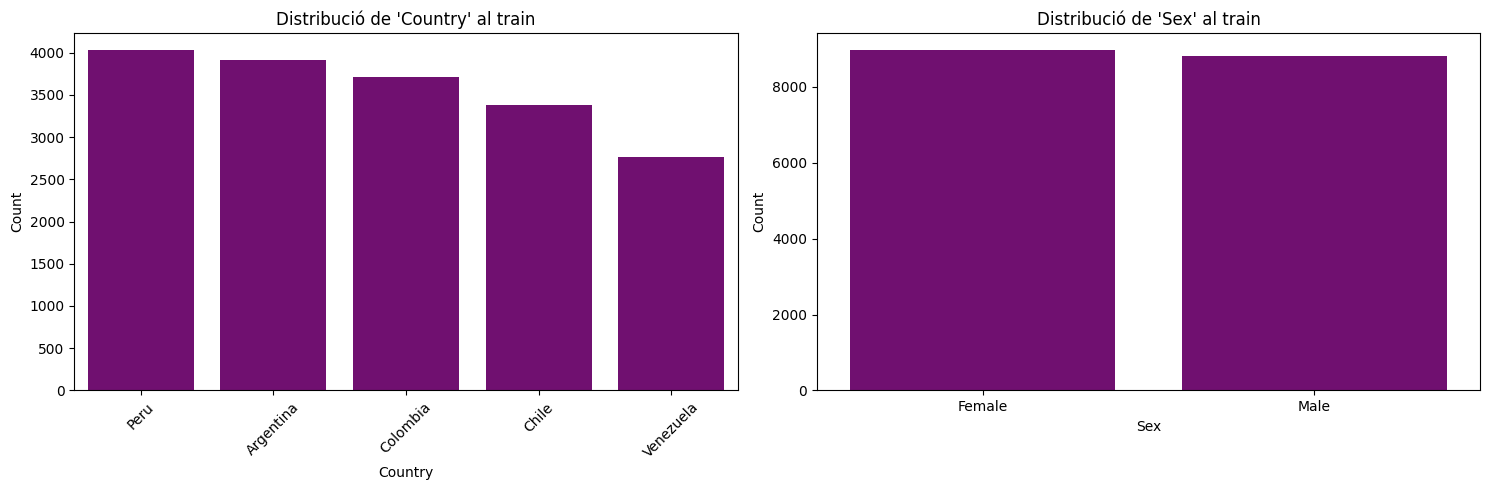

In [213]:
country_counts = train['Country'].value_counts()
sex_counts = train['Sex'].value_counts()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

sns.barplot(x=country_counts.index, y=country_counts.values, ax=axes[0], color='purple')
axes[0].set_title("Distribució de 'Country' al train")
axes[0].set_xlabel('Country')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(x=sex_counts.index, y=sex_counts.values, ax=axes[1], color='purple')
axes[1].set_title("Distribució de 'Sex' al train")
axes[1].set_xlabel('Sex')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show();

Podem veure que més o menys estan balancejades, així que per confirmar fem taules de contingència per veure les seves relacions amb la variable objectiu

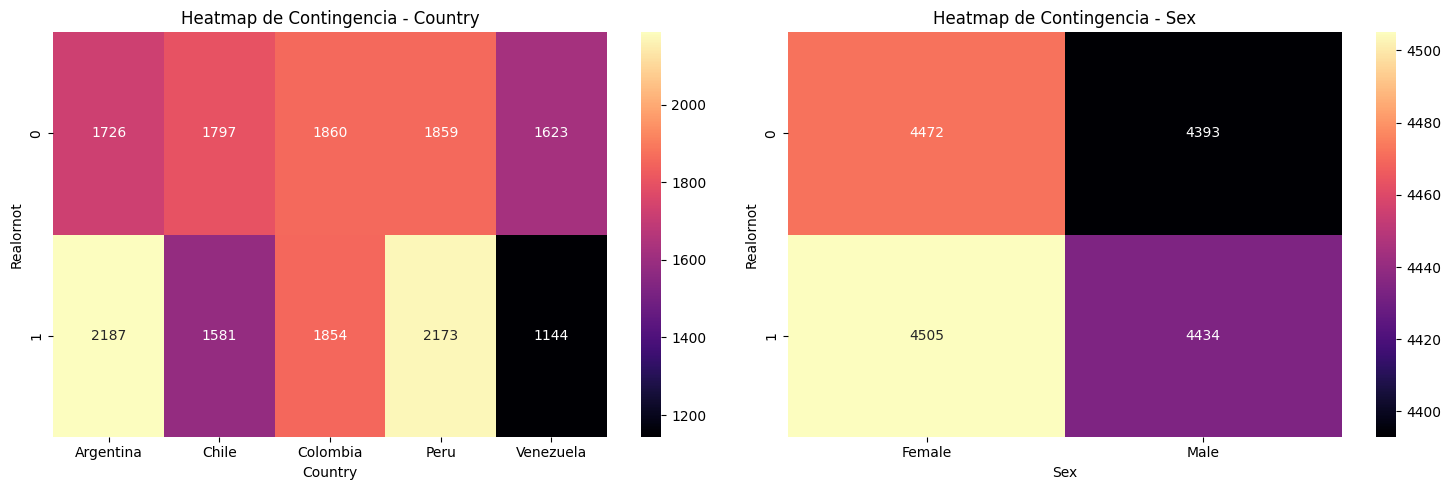

In [214]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

contingency_table_country = pd.crosstab(train['Realornot'], train['Country'])
sns.heatmap(contingency_table_country, annot=True, fmt="d", cmap="magma", ax=axes[0])
axes[0].set_title("Heatmap de Contingencia - Country")

contingency_table_sex = pd.crosstab(train['Realornot'], train['Sex'])
sns.heatmap(contingency_table_sex, annot=True, fmt="d", cmap="magma", ax=axes[1])
axes[1].set_title("Heatmap de Contingencia - Sex")

plt.tight_layout()
plt.show();


Tot i que no estan del tot balancejades, especialment el Country, considerem que per la poca diferència entre els valors de realornot, tampoc és necessari balancejar la classe ja que l'esbiaix segurament no serà significatiu

A continuació codifiquem les variables amb el label encoder per poder-les utilitzar als models

In [215]:
from sklearn.preprocessing import LabelEncoder

label_encoder_sex = LabelEncoder()
label_encoder_country = LabelEncoder()

train_scaled_df = train[['Country','Sex']].copy()
test_scaled_df = test[['Country','Sex']].copy()

train_scaled_df['Sex'] = label_encoder_sex.fit_transform(train['Sex'])
train_scaled_df['Country'] = label_encoder_country.fit_transform(train['Country'])

test_scaled_df['Sex'] = label_encoder_sex.transform(test['Sex'])
test_scaled_df['Country'] = label_encoder_country.transform(test['Country'])

display(train_scaled_df.values)


array([[0, 0],
       [0, 0],
       [0, 0],
       ...,
       [4, 1],
       [4, 1],
       [4, 1]])

Ara ajuntem ambdós datasets i els unifiquem amb realornot, tot i que primer hem d'escalar les dades a un rang de [0,1] per evitaar futurs problemes amb les distàncies

In [216]:
from sklearn.preprocessing import MinMaxScaler

scaler_country = MinMaxScaler()
train_scaled_df['Country'] = scaler_country.fit_transform(train_scaled_df[['Country']])
test_scaled_df['Country'] = scaler_country.transform(test_scaled_df[['Country']])

display(train_scaled_df.head())

train_preprocessed[train_scaled_df.columns] = train_scaled_df.copy()
test_preprocessed[test_scaled_df.columns] = test_scaled_df.copy()

,Country,Sex
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0


Després fem un correlation matrix per veure les dependències entre variables, especialment el realornot

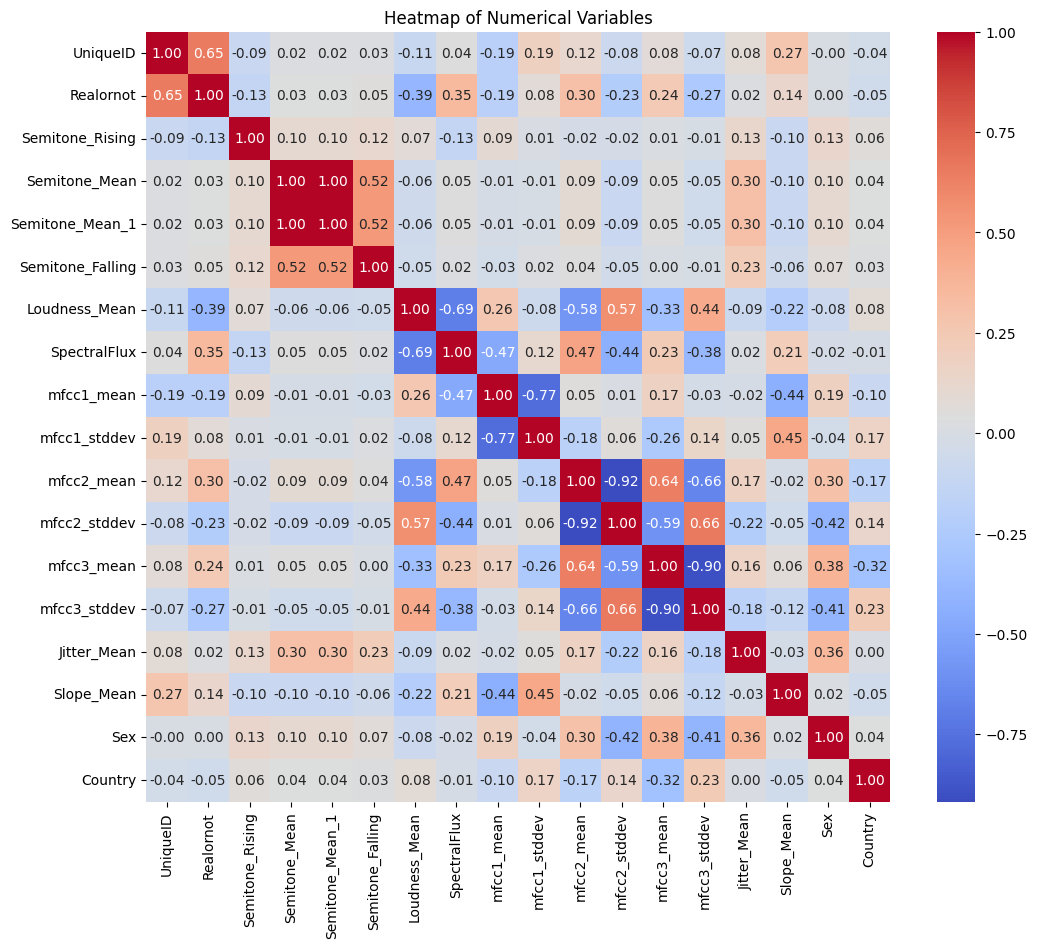

In [217]:
plt.figure(figsize=(12, 10))
correlation_matrix = train_preprocessed.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap of Numerical Variables')
plt.show();

Ara fem un test anova per veure les 7 variables més correlacionades, que hem vist al correlation matrix que són les més significatives

In [218]:
from sklearn.feature_selection import SelectKBest, f_classif

X = train_preprocessed.drop(['UniqueID', 'Realornot'], axis=1)
y = train_preprocessed['Realornot']

anova_selector = SelectKBest(f_classif, k=7)
X_kbest = anova_selector.fit_transform(X, y)

selected_features = X.columns[anova_selector.get_support()]
print("Selected features using ANOVA F-test:", selected_features)

Selected features using ANOVA F-test: Index(['Loudness_Mean', 'SpectralFlux', 'mfcc1_mean', 'mfcc2_mean',
       'mfcc2_stddev', 'mfcc3_mean', 'mfcc3_stddev'],
      dtype='object')


També fem un pca per veure si hauriem de reduir el nombre de dimensions

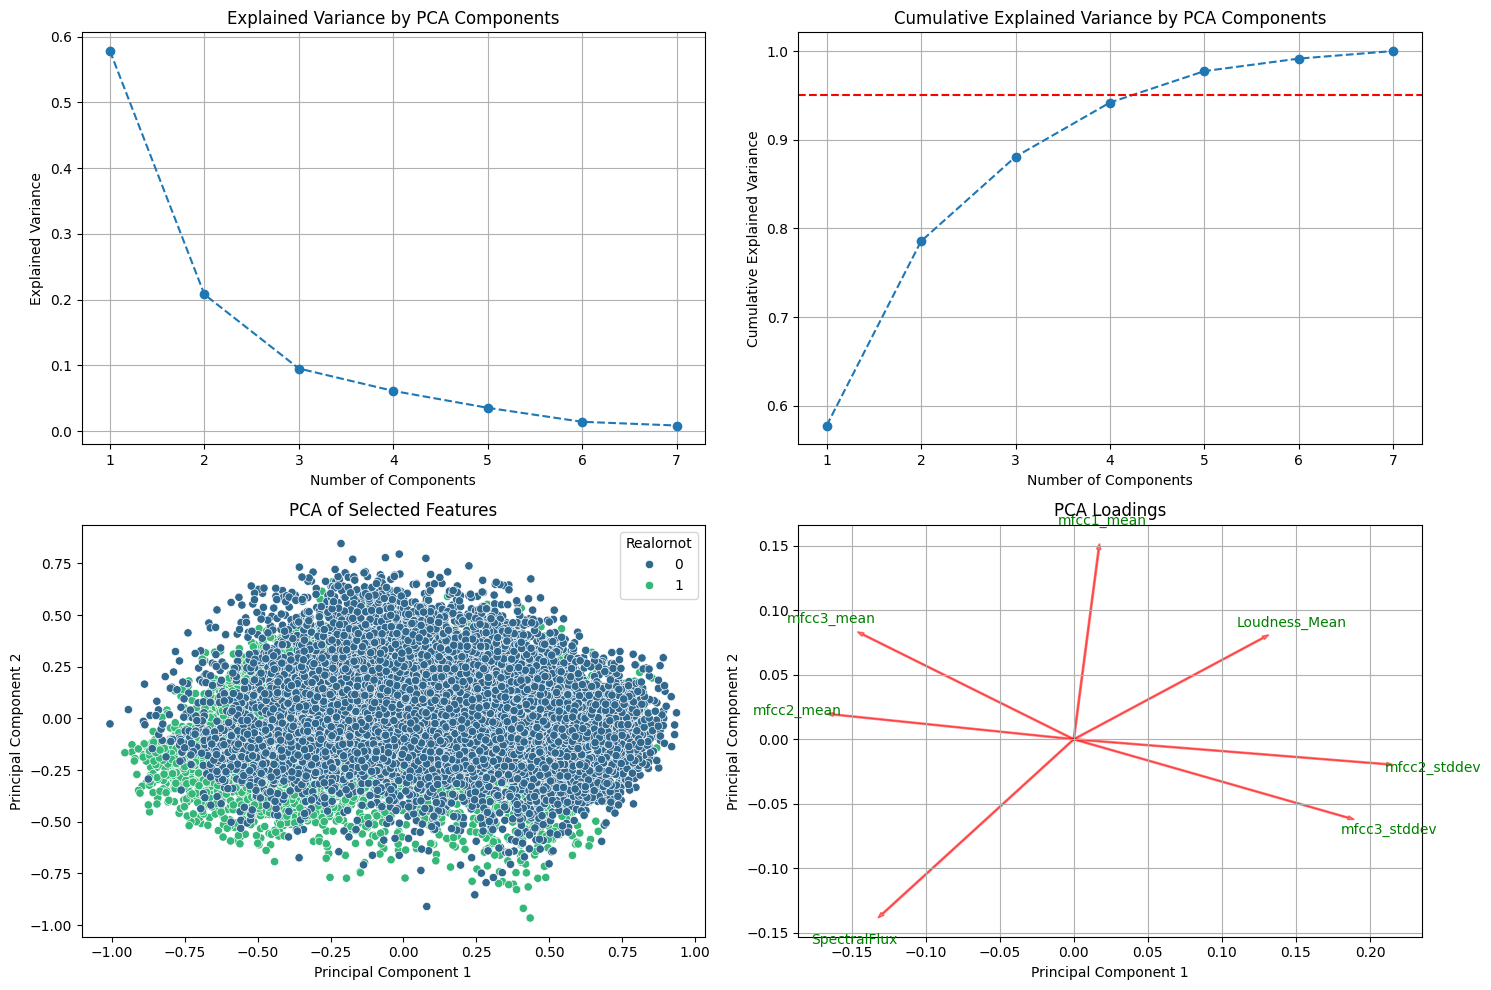

In [219]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

variables_pca = ['Loudness_Mean', 'SpectralFlux', 'mfcc1_mean', 'mfcc2_mean', 'mfcc2_stddev', 'mfcc3_mean', 'mfcc3_stddev']

pca = PCA()
pca_result = pca.fit_transform(train_preprocessed[variables_pca])

explained_variance = pca.explained_variance_ratio_

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

#Mètode del colze
axes[0, 0].plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
axes[0, 0].set_title('Explained Variance by PCA Components')
axes[0, 0].set_xlabel('Number of Components')
axes[0, 0].set_ylabel('Explained Variance')
axes[0, 0].grid(True)

#Cumulative variance
cumulative_variance = explained_variance.cumsum()
axes[0, 1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
axes[0, 1].set_title('Cumulative Explained Variance by PCA Components')
axes[0, 1].set_xlabel('Number of Components')
axes[0, 1].set_ylabel('Cumulative Explained Variance')
axes[0, 1].axhline(y=0.95, color='r', linestyle='--')
axes[0, 1].grid(True)

# Visualitzar PCA amb 2 components
n_components = next(i for i, total_var in enumerate(cumulative_variance) if total_var >= 0.95) + 1
pca_optimal = PCA(n_components=n_components)
train_pca = pca_optimal.fit_transform(train_preprocessed[variables_pca])
train_pca_df = pd.DataFrame(data=train_pca, columns=[f'PCA{i+1}' for i in range(n_components)])
train_pca_df['Realornot'] = train_preprocessed['Realornot']

sns.scatterplot(x='PCA1', y='PCA2', hue='Realornot', data=train_pca_df, palette='viridis', ax=axes[1, 0])
axes[1, 0].set_title('PCA of Selected Features')
axes[1, 0].set_xlabel('Principal Component 1')
axes[1, 0].set_ylabel('Principal Component 2')
axes[1, 0].legend(title='Realornot')

# Gràfic dels loadings
loadings = pca_optimal.components_.T * np.sqrt(pca_optimal.explained_variance_)
for i, var in enumerate(variables_pca):
    axes[1, 1].arrow(0, 0, loadings[i, 0], loadings[i, 1], color='r', alpha=0.5)
    axes[1, 1].text(loadings[i, 0] * 1.15, loadings[i, 1] * 1.15, var, color='g', ha='center', va='center')
axes[1, 1].set_title('PCA Loadings')
axes[1, 1].set_xlabel('Principal Component 1')
axes[1, 1].set_ylabel('Principal Component 2')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show();

Com podem veure als gràfics anteriors, podriem arribar a reduir la dimensionalitat en certa mesura dintre el conjunt de train. El número idoni maximitzant la variança seria de 5 components, cosa que es relaciona amb les similituds dels mfcc_mean i mfcc_sttdev.

Tot i això, tenint en compte que estem parlant de només 7 dimensions, aquesta pèrdua d'informació no implica una gran millora respecte la explicabilitat que perd el model, a més que amb dimensionalitats d'aquestes magnituds les distàncies no són tant problemàtiques com per requerir d'un mètode de reducció de dimensionalitat. 

Per aquest motiu s'ha decidit realitzar els models sense el PCA.

## Selecció de categòriques
Fem un chi-quadrat per veure quines variables categòriques estan relacionades amb Realornot

**Valor chi-quadrat (chi2)**: Mesura la diferència entre les freqüències observades i les esperades. Un valor baix indica poca diferència.

**Valor p (p-value)**: Indica la probabilitat d'obtenir un resultat tan extrem com l'observat sota la hipòtesi nul·la. Un valor p alt (més gran que 0.05) suggereix que no hi ha evidència suficient per rebutjar la hipòtesi nul·la.

1. **Sex: chi2=0.0024642795791689, p-value=0.9604080666805683**
    
    Com que el valor p és molt alt (0.9604), no hi ha evidència suficient per rebutjar la hipòtesi nul·la. Això significa que no hi ha una associació significativa entre la variable "Sex" i la variable "Realornot".

2. **Country: chi2=175.2022615307704, p-value=7.993768458933562e-37**
    
    Com que el valor p és extremadament baix (7.993768458933562e-37), hi ha evidència suficient per rebutjar la hipòtesi nul·la. Això significa que hi ha una associació significativa entre la variable "Country" i la variable "Realornot".

Així doncs concluim que la variable Country està relacionada amb la variable objectiu i per tant l'hem d'incloure al model.


In [220]:
from scipy.stats import chi2_contingency

contingency_sex = pd.crosstab(train['Sex'], train['Realornot'])
contingency_country = pd.crosstab(train['Country'], train['Realornot'])

chi2_sex, p_sex, dof_sex, expected_sex = chi2_contingency(contingency_sex)
print(f"Chi2 test for Sex: chi2={chi2_sex}, p-value={p_sex}")

chi2_country, p_country, dof_country, expected_country = chi2_contingency(contingency_country)
print(f"Chi2 test for Country: chi2={chi2_country}, p-value={p_country}")

Chi2 test for Sex: chi2=0.0024642795791689, p-value=0.9604080666805683
Chi2 test for Country: chi2=175.2022615307704, p-value=7.993768458933562e-37


Veiem que el Semitone Mean està duplicada així que eliminem la variable i seleccionem les significatives

In [221]:
train_pre = train_preprocessed.copy()
train_pre.drop(['Semitone_Mean_1'], axis=1, inplace=True)

v_significatives = ['Loudness_Mean', 'SpectralFlux', 'mfcc1_mean', 'mfcc2_mean', 'mfcc2_stddev', 'mfcc3_mean', 'mfcc3_stddev', 'Sex']

# Models
### SVM

In [222]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
import pandas as pd

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train = train_preprocessed[v_significatives]
y_train = train_preprocessed['Realornot']
X_test = test_preprocessed[v_significatives]
y_test = test_preprocessed['Realornot']

# Definir els hiperparàmetres
param_grid = {
    'C': [0.1, 1, 100],
    'gamma': [0.01, 0.1, 1],
    'kernel': ['rbf']
}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=SVC(random_state=42), 
    param_grid=param_grid, 
    cv=3, 
    scoring='f1', 
    verbose=1
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
test_pred = best_model.predict(test_preprocessed[v_significatives])

results_df_svm = pd.DataFrame(grid_search.cv_results_['params'])
results_df_svm['f1'] = grid_search.cv_results_['mean_test_score']

results_df_svm['accuracy'] = [
    accuracy_score(y_test, SVC(**params, random_state=42).fit(X_train, y_train).predict(X_test))
    for params in grid_search.cv_results_['params']
]

accuracy_test = accuracy_score(test['Realornot'], test_pred)
f1_test = f1_score(test['Realornot'], test_pred)

print("\nMillors hiperparàmetres:", best_params)
print("\nAccuracy Test:", accuracy_test)
print("\nF1 Test:", f1_test)
print("\nClassification Test Report:\n", classification_report(test['Realornot'], test_pred))

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3, estimator=SVC(random_state=42),
             param_grid={'C': [0.1, 1, 100], 'gamma': [0.01, 0.1, 1],
                         'kernel': ['rbf']},
             scoring='f1', verbose=1)


Millors hiperparàmetres: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}

Accuracy Test: 0.7592748735244519

F1 Test: 0.7670338637290902

Classification Test Report:
               precision    recall  f1-score   support

           0       0.77      0.73      0.75      1172
           1       0.75      0.78      0.77      1200

    accuracy                           0.76      2372
   macro avg       0.76      0.76      0.76      2372
weighted avg       0.76      0.76      0.76      2372



In [223]:
print("\nResultats del grid search ordenats per accuracy:\n")
display(results_df_svm.sort_values(by='accuracy', ascending=False))


Resultats del grid search ordenats per accuracy:



,C,gamma,kernel,f1,accuracy
8,100.0,1.00,rbf,0.706026,0.759275
5,1.0,1.00,rbf,0.701116,0.745363
7,100.0,0.10,rbf,0.703912,0.739039
2,0.1,1.00,rbf,0.684524,0.695616
6,100.0,0.01,rbf,0.679158,0.688027
4,1.0,0.10,rbf,0.680156,0.684654
3,1.0,0.01,rbf,0.660994,0.658094
1,0.1,0.10,rbf,0.666554,0.657673
0,0.1,0.01,rbf,0.666874,0.632378


### Curva ROC del model escollit

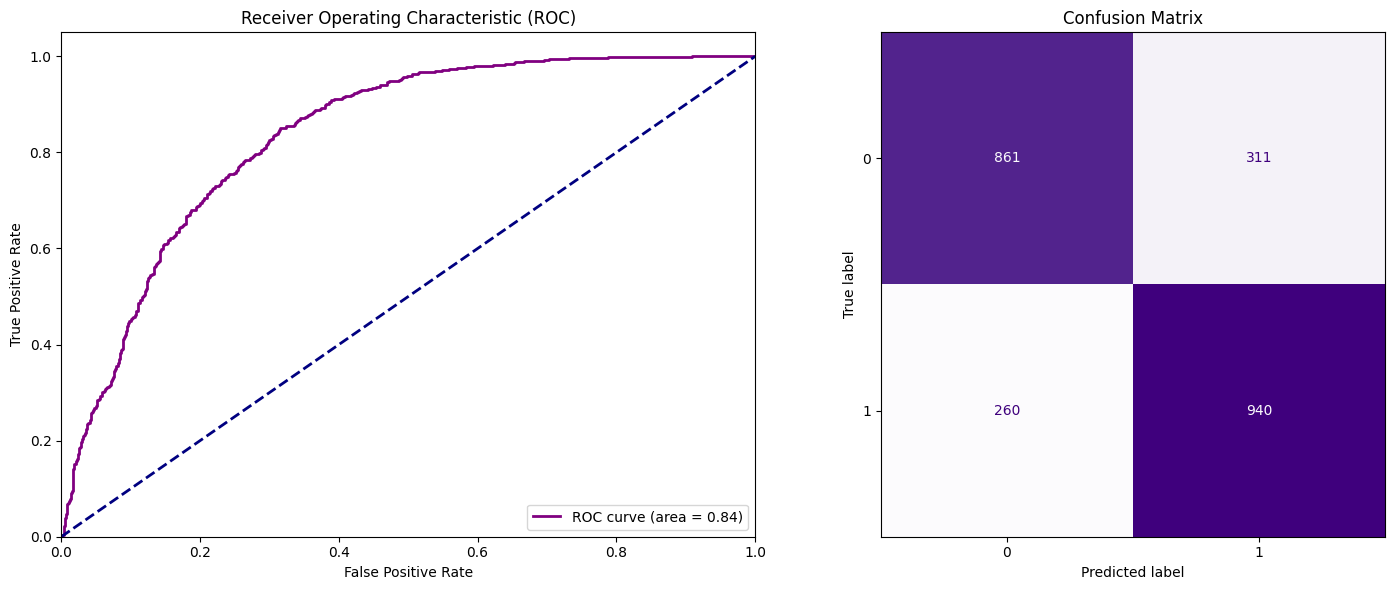

In [224]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_prob = best_model.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

axes[0].plot(fpr, tpr, color='purple', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Receiver Operating Characteristic (ROC)')
axes[0].legend(loc="lower right")

conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Purples, ax=axes[1], colorbar=False)
axes[1].set_title('Confusion Matrix')

plt.tight_layout()
plt.show();

## KNN

In [225]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
import pandas as pd

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=KNeighborsClassifier(), 
    param_grid=param_grid, 
    cv=3, 
    scoring='f1', 
    verbose=1
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
test_pred = best_model.predict(test_preprocessed[v_significatives])

results_df_knn = pd.DataFrame(grid_search.cv_results_['params'])
results_df_knn['f1'] = grid_search.cv_results_['mean_test_score']

results_df_knn['accuracy'] = [
    accuracy_score(y_test, KNeighborsClassifier(**params).fit(X_train, y_train).predict(X_test))
    for params in grid_search.cv_results_['params']
]

accuracy_test = accuracy_score(test['Realornot'], test_pred)
f1_test = f1_score(test['Realornot'], test_pred)

print("\nMillors hiperparàmetres:", best_params)
print("\nAccuracy Test:", accuracy_test)
print("\nF1 Test:", f1_test)
print("\nClassification Test Report:\n", classification_report(test['Realornot'], test_pred))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [3, 5, 7, 9, 11],
                         'weights': ['uniform', 'distance']},
             scoring='f1', verbose=1)


Millors hiperparàmetres: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}

Accuracy Test: 0.7099494097807757

F1 Test: 0.7333333333333333

Classification Test Report:
               precision    recall  f1-score   support

           0       0.74      0.63      0.68      1172
           1       0.69      0.79      0.73      1200

    accuracy                           0.71      2372
   macro avg       0.71      0.71      0.71      2372
weighted avg       0.71      0.71      0.71      2372



In [226]:
print("\nResultats del grid search ordenats per accuracy:\n")
display(results_df_knn.sort_values(by='accuracy', ascending=False))


Resultats del grid search ordenats per accuracy:



,metric,n_neighbors,weights,f1,accuracy
8,euclidean,11,uniform,0.676316,0.714587
28,minkowski,11,uniform,0.676316,0.714587
29,minkowski,11,distance,0.676586,0.714165
9,euclidean,11,distance,0.676586,0.714165
19,manhattan,11,distance,0.678186,0.712057
24,minkowski,7,uniform,0.667929,0.710371
4,euclidean,7,uniform,0.667929,0.710371
16,manhattan,9,uniform,0.675500,0.710371
18,manhattan,11,uniform,0.678367,0.709949
26,minkowski,9,uniform,0.670552,0.709528


## Decision Tree

In [227]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
import pandas as pd

param_grid = {
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=3, 
    scoring='f1', 
    verbose=1
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
test_pred = best_model.predict(test_preprocessed[v_significatives])

results_df_tree = pd.DataFrame(grid_search.cv_results_['params'])
results_df_tree['f1'] = grid_search.cv_results_['mean_test_score']

results_df_tree['accuracy'] = [
    accuracy_score(y_test, DecisionTreeClassifier(**params, random_state=42).fit(X_train, y_train).predict(X_test))
    for params in grid_search.cv_results_['params']
]

accuracy_test = accuracy_score(test['Realornot'], test_pred)
f1_test = f1_score(test['Realornot'], test_pred)

print("\nMillors hiperparàmetres:", best_params)
print("\nAccuracy Test:", accuracy_test)
print("\nF1 Test:", f1_test)
print("\nClassification Test Report:\n", classification_report(test['Realornot'], test_pred))

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='f1', verbose=1)


Millors hiperparàmetres: {'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 2}

Accuracy Test: 0.6850758853288365

F1 Test: 0.691958762886598

Classification Test Report:
               precision    recall  f1-score   support

           0       0.69      0.67      0.68      1172
           1       0.68      0.70      0.69      1200

    accuracy                           0.69      2372
   macro avg       0.69      0.68      0.68      2372
weighted avg       0.69      0.69      0.69      2372



In [228]:
print("\nResultats del grid search ordenats per accuracy:\n")
display(results_df_tree.sort_values(by='accuracy', ascending=False))


Resultats del grid search ordenats per accuracy:



,criterion,min_samples_leaf,min_samples_split,f1,accuracy
17,entropy,4,10,0.633023,0.699410
16,entropy,4,5,0.631910,0.698567
15,entropy,4,2,0.631910,0.698567
12,entropy,2,2,0.627592,0.690978
10,entropy,1,5,0.631453,0.688027
13,entropy,2,5,0.629598,0.688027
14,entropy,2,10,0.636624,0.686762
11,entropy,1,10,0.633957,0.685076
9,entropy,1,2,0.638757,0.685076
8,gini,4,10,0.637795,0.680860


### Provem sense imputar outliers
Després de tractar els missings, hauriem de tractar outliers. Tot i això, en el cas de la veu aquest outliers podrien aportar informació rellevant al model tenint en compte que potser són fenòmens naturals en la parla o pics artificials. Així doncs farem experimentació amb i sense imputació d'outliers.

Així doncs el primer que hem de fer és transformar logarítmicament les dades amb distribucions log-normals.

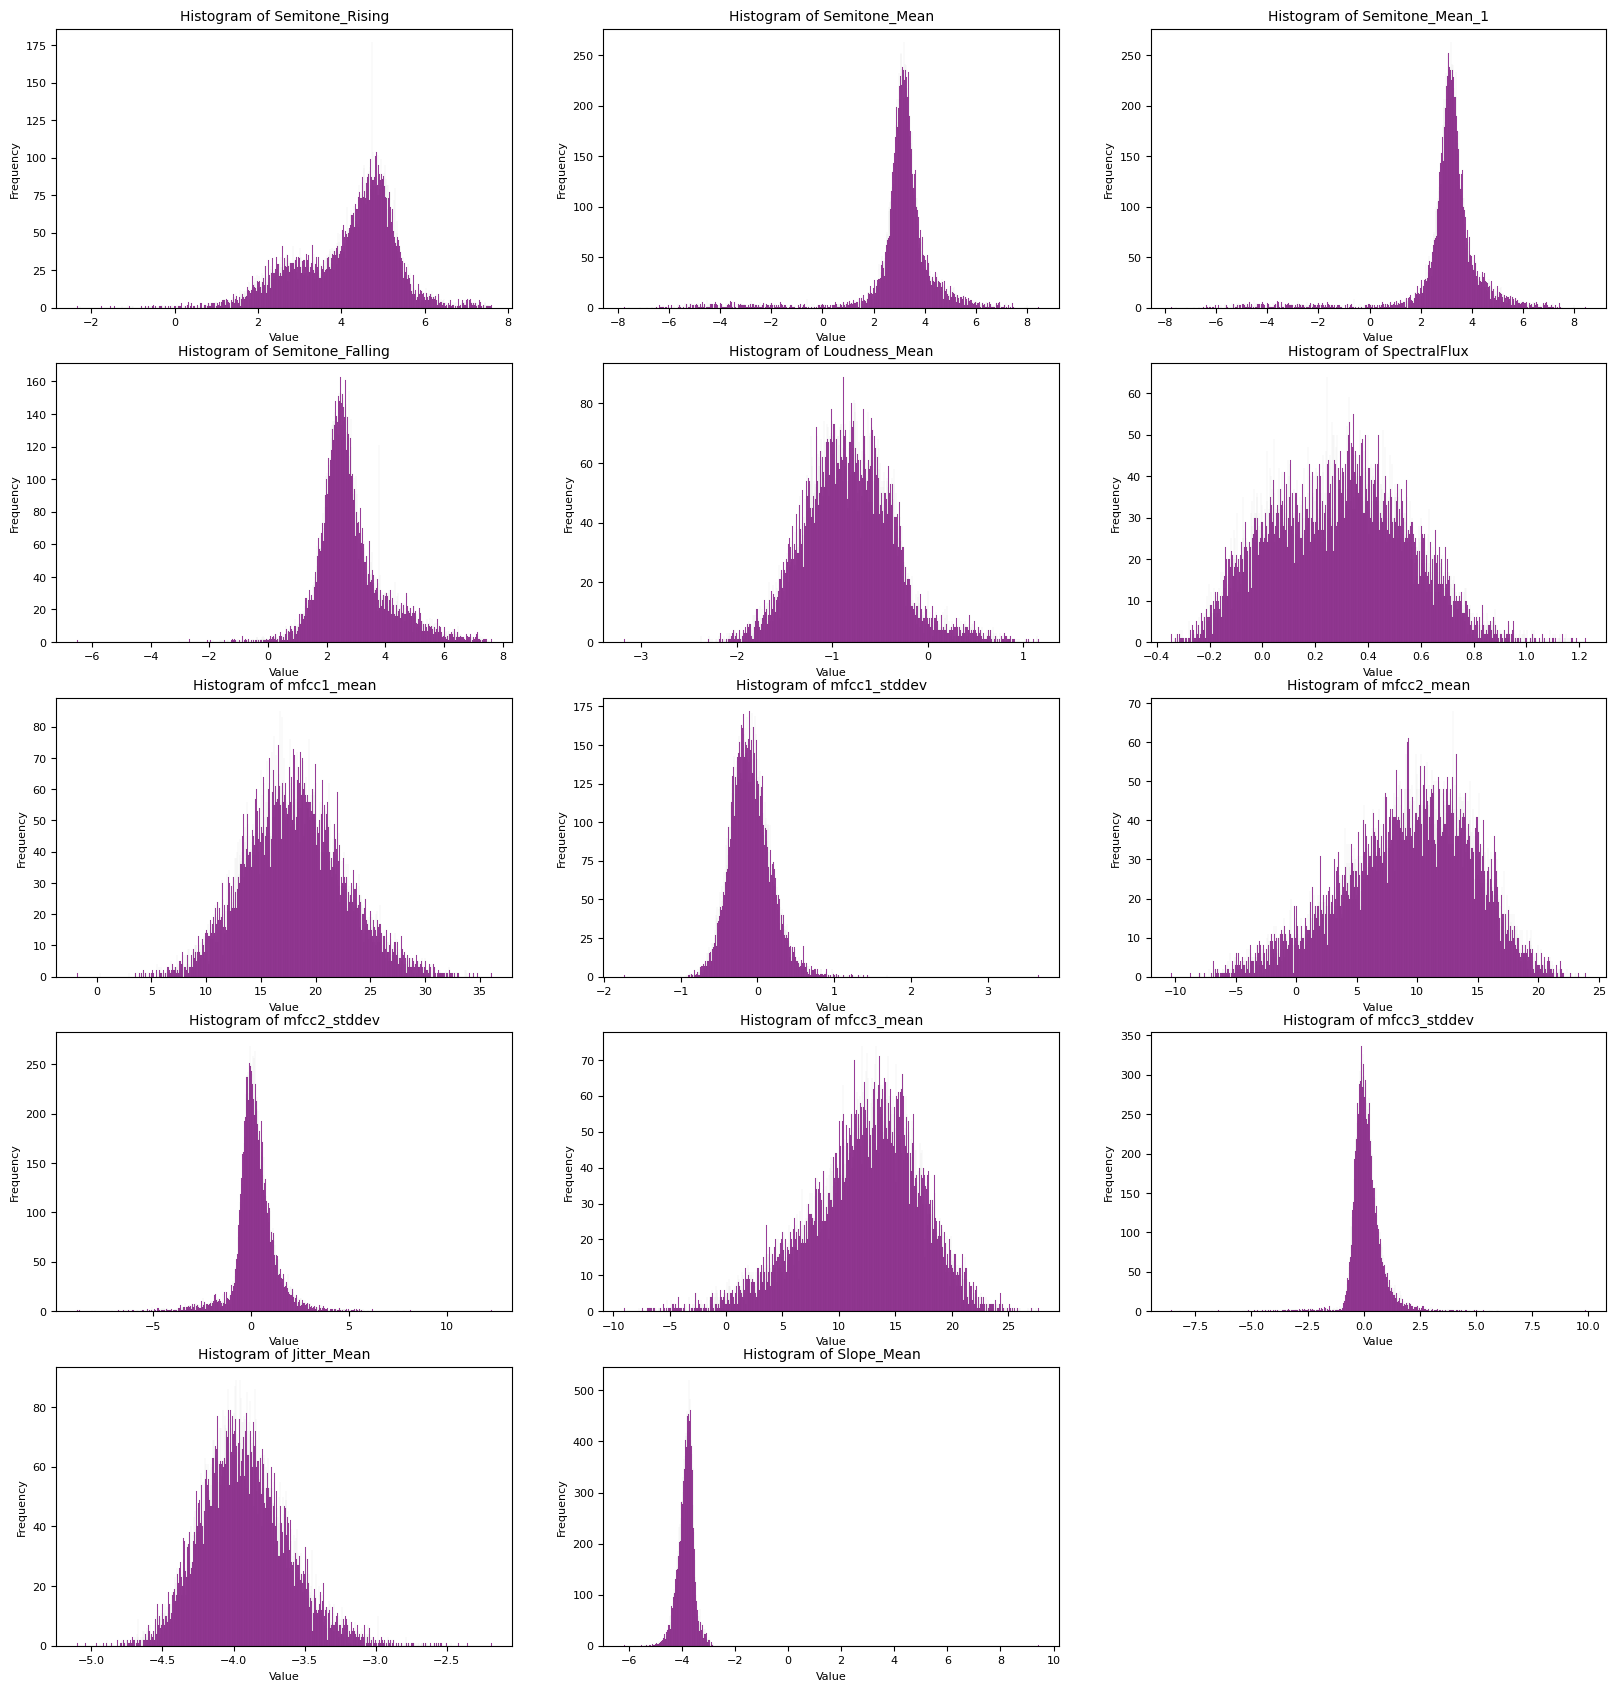

In [229]:
import numpy as np

train_log = train_numeriques.copy()
test_log = test_numeriques.copy()

columnes_cua = ['Semitone_Rising', 'Semitone_Mean', 'Semitone_Mean_1', 'Semitone_Falling', 'Loudness_Mean', 'SpectralFlux',
                'mfcc1_stddev', 'mfcc2_stddev', 'mfcc3_stddev', 'Jitter_Mean', 'Slope_Mean']

epsilon = 1e-6
for col in columnes_cua:
    train_log[col] = np.sign(train_log[col]) * np.log(np.abs(train_log[col]) + epsilon)
    test_log[col] = np.sign(test_log[col]) * np.log(np.abs(test_log[col]) + epsilon)

plot_histograms(train_log)

A continuació escalem les dades després d'haver-les normalitzat

In [230]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

train_scaled = pd.DataFrame(scaler.fit_transform(train_log), columns=train_log.columns)
test_scaled = pd.DataFrame(scaler.transform(test_log), columns=test_log.columns)


Ara ajuntem els dataframes per poder modelar a posteriori

In [231]:
train_pre = train_preprocessed.copy()
test_pre = test_preprocessed.copy()

train_pre[train_scaled.columns] = train_scaled.copy()
test_pre[test_scaled.columns] = test_scaled.copy()

Mirem la matriu de correlació

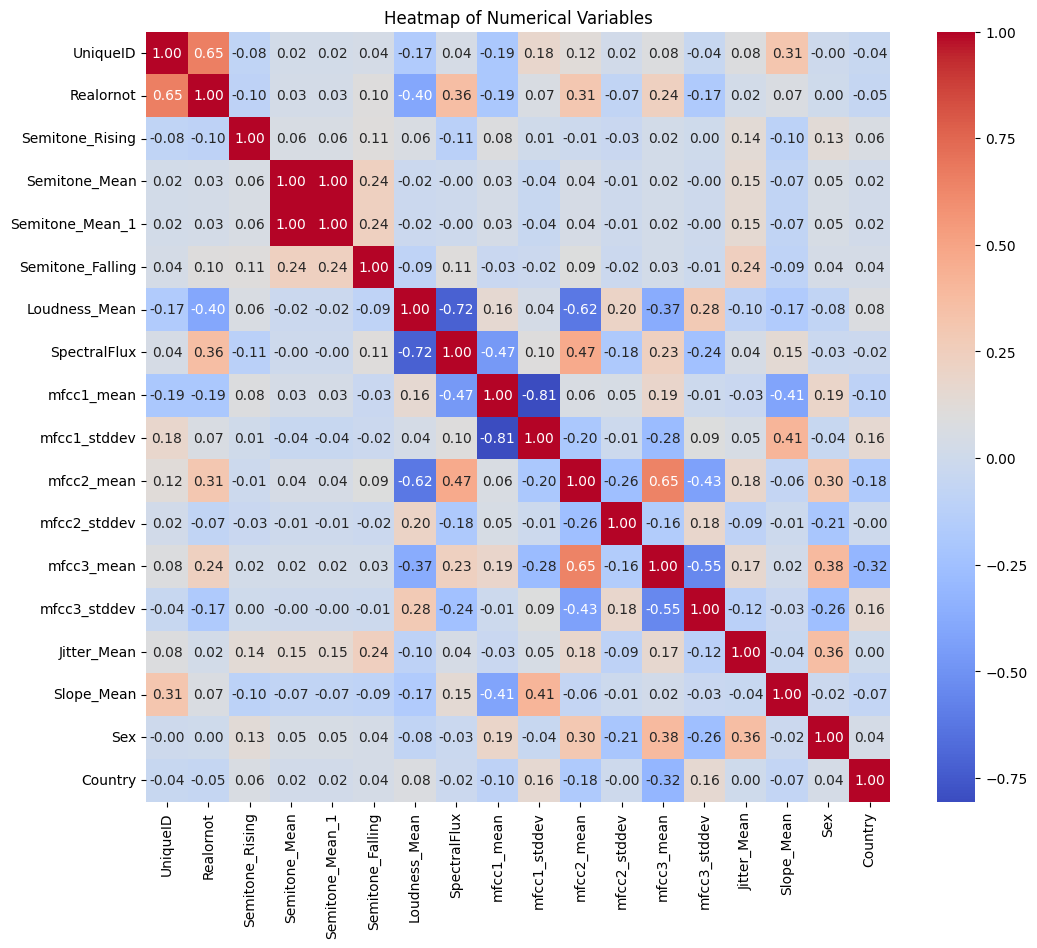

In [232]:
plt.figure(figsize=(12, 10))
correlation_matrix = train_pre.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap of Numerical Variables')
plt.show();

Veiem que ara només estàn correlacionades 6 variables

In [233]:
v_significatives = ['Loudness_Mean', 'SpectralFlux', 'mfcc1_mean', 'mfcc2_mean','mfcc3_mean','mfcc3_stddev','Country',]

# Models sense imputació
## SVM

In [234]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
import pandas as pd

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train = train_pre[v_significatives]
y_train = train_pre['Realornot']
X_test = test_pre[v_significatives]
y_test = test_pre['Realornot']

# Definir los hiperparámetros para el GridSearchCV
param_grid = {
    'C': [0.1, 1, 100],
    'gamma': [0.01, 0.1, 1],
    'kernel': ['rbf']
}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=SVC(random_state=42), 
    param_grid=param_grid, 
    cv=3, 
    scoring='f1', 
    verbose=1
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
test_pred = best_model.predict(test_preprocessed[v_significatives])

results_df_svm_o = pd.DataFrame(grid_search.cv_results_['params'])
results_df_svm_o['f1'] = grid_search.cv_results_['mean_test_score']

results_df_svm_o['accuracy'] = [
    accuracy_score(y_test, SVC(**params, random_state=42).fit(X_train, y_train).predict(X_test))
    for params in grid_search.cv_results_['params']
]

accuracy_test = accuracy_score(test['Realornot'], test_pred)
f1_test = f1_score(test['Realornot'], test_pred)

print("\nMillors hiperparàmetres:", best_params)
print("\nAccuracy Test:", accuracy_test)
print("\nF1 Test:", f1_test)
print("\nClassification Test Report:\n", classification_report(test['Realornot'], test_pred))

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3, estimator=SVC(random_state=42),
             param_grid={'C': [0.1, 1, 100], 'gamma': [0.01, 0.1, 1],
                         'kernel': ['rbf']},
             scoring='f1', verbose=1)


Millors hiperparàmetres: {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}

Accuracy Test: 0.6589376053962901

F1 Test: 0.7113806635747414

Classification Test Report:
               precision    recall  f1-score   support

           0       0.74      0.48      0.58      1172
           1       0.62      0.83      0.71      1200

    accuracy                           0.66      2372
   macro avg       0.68      0.66      0.65      2372
weighted avg       0.68      0.66      0.65      2372



In [235]:
print("\nResultats del grid search ordenats per accuracy:\n")
display(results_df_svm_o.sort_values(by='accuracy', ascending=False))


Resultats del grid search ordenats per accuracy:



,C,gamma,kernel,f1,accuracy
7,100.0,0.10,rbf,0.384853,0.770236
4,1.0,0.10,rbf,0.545636,0.764755
6,100.0,0.01,rbf,0.523235,0.762226
5,1.0,1.00,rbf,0.461738,0.759275
2,0.1,1.00,rbf,0.552665,0.755059
1,0.1,0.10,rbf,0.568018,0.739039
8,100.0,1.00,rbf,0.412703,0.715008
3,1.0,0.01,rbf,0.509737,0.695616
0,0.1,0.01,rbf,0.593117,0.667369


## KNN

In [236]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
import pandas as pd

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=KNeighborsClassifier(), 
    param_grid=param_grid, 
    cv=3, 
    scoring='f1', 
    verbose=1
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
test_pred = best_model.predict(test_preprocessed[v_significatives])

results_df_knn_o = pd.DataFrame(grid_search.cv_results_['params'])
results_df_knn_o['f1'] = grid_search.cv_results_['mean_test_score']

results_df_knn_o['accuracy'] = [
    accuracy_score(y_test, KNeighborsClassifier(**params).fit(X_train, y_train).predict(X_test))
    for params in grid_search.cv_results_['params']
]

accuracy_test = accuracy_score(test['Realornot'], test_pred)
f1_test = f1_score(test['Realornot'], test_pred)

print("\nMillors hiperparàmetres:", best_params)
print("\nAccuracy Test:", accuracy_test)
print("\nF1 Test:", f1_test)
print("\nClassification Test Report:\n", classification_report(test['Realornot'], test_pred))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [3, 5, 7, 9, 11],
                         'weights': ['uniform', 'distance']},
             scoring='f1', verbose=1)


Millors hiperparàmetres: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}

Accuracy Test: 0.4881956155143339

F1 Test: 0.5904183535762483

Classification Test Report:
               precision    recall  f1-score   support

           0       0.47      0.24      0.32      1172
           1       0.50      0.73      0.59      1200

    accuracy                           0.49      2372
   macro avg       0.48      0.49      0.45      2372
weighted avg       0.48      0.49      0.46      2372



In [237]:
print("\nResultats del grid search ordenats per accuracy:\n")
display(results_df_knn_o.sort_values(by='accuracy', ascending=False))


Resultats del grid search ordenats per accuracy:



,metric,n_neighbors,weights,f1,accuracy
16,manhattan,9,uniform,0.559040,0.731450
28,minkowski,11,uniform,0.587333,0.730607
8,euclidean,11,uniform,0.587333,0.730607
29,minkowski,11,distance,0.584520,0.729764
9,euclidean,11,distance,0.584520,0.729764
17,manhattan,9,distance,0.556668,0.729764
18,manhattan,11,uniform,0.561344,0.724283
19,manhattan,11,distance,0.559417,0.723862
26,minkowski,9,uniform,0.581016,0.722597
6,euclidean,9,uniform,0.581016,0.722597


In [238]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
import pandas as pd

param_grid = {
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=3, 
    scoring='f1', 
    verbose=1
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
test_pred = best_model.predict(test_preprocessed[v_significatives])

results_df_tree_o = pd.DataFrame(grid_search.cv_results_['params'])
results_df_tree_o['f1'] = grid_search.cv_results_['mean_test_score']

results_df_tree_o['accuracy'] = [
    accuracy_score(y_test, DecisionTreeClassifier(**params, random_state=42).fit(X_train, y_train).predict(X_test))
    for params in grid_search.cv_results_['params']
]

accuracy_test = accuracy_score(test['Realornot'], test_pred)
f1_test = f1_score(test['Realornot'], test_pred)

print("\nMillors hiperparàmetres:", best_params)
print("\nAccuracy Test:", accuracy_test)
print("\nF1 Test:", f1_test)
print("\nClassification Test Report:\n", classification_report(test['Realornot'], test_pred))

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='f1', verbose=1)


Millors hiperparàmetres: {'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 2}

Accuracy Test: 0.5227655986509275

F1 Test: 0.5243697478991597

Classification Test Report:
               precision    recall  f1-score   support

           0       0.52      0.53      0.52      1172
           1       0.53      0.52      0.52      1200

    accuracy                           0.52      2372
   macro avg       0.52      0.52      0.52      2372
weighted avg       0.52      0.52      0.52      2372



In [239]:
print("\nResultats del grid search ordenats per accuracy:\n")
display(results_df_tree_o.sort_values(by='accuracy', ascending=False))


Resultats del grid search ordenats per accuracy:



,criterion,min_samples_leaf,min_samples_split,f1,accuracy
5,gini,2,10,0.248112,0.693508
8,gini,4,10,0.244259,0.693086
7,gini,4,5,0.251689,0.690135
6,gini,4,2,0.251689,0.690135
4,gini,2,5,0.261804,0.689292
2,gini,1,10,0.255914,0.687184
17,entropy,4,10,0.245902,0.683811
9,entropy,1,2,0.259990,0.682968
3,gini,2,2,0.257692,0.682968
14,entropy,2,10,0.250077,0.682125


Fem una comparativa entre els models amb i sense imputar outliers
## SVM

In [240]:
merged_results_svm = pd.merge(results_df_svm, results_df_svm_o, on=results_df_svm.drop(['accuracy', 'f1'], axis=1).columns.tolist(), suffixes=('_svm', '_svm_no_outliers'))
display(merged_results_svm.sort_values(by='accuracy_svm', ascending=False))

,C,gamma,kernel,f1_svm,accuracy_svm,f1_svm_no_outliers,accuracy_svm_no_outliers
8,100.0,1.00,rbf,0.706026,0.759275,0.412703,0.715008
5,1.0,1.00,rbf,0.701116,0.745363,0.461738,0.759275
7,100.0,0.10,rbf,0.703912,0.739039,0.384853,0.770236
2,0.1,1.00,rbf,0.684524,0.695616,0.552665,0.755059
6,100.0,0.01,rbf,0.679158,0.688027,0.523235,0.762226
4,1.0,0.10,rbf,0.680156,0.684654,0.545636,0.764755
3,1.0,0.01,rbf,0.660994,0.658094,0.509737,0.695616
1,0.1,0.10,rbf,0.666554,0.657673,0.568018,0.739039
0,0.1,0.01,rbf,0.666874,0.632378,0.593117,0.667369


In [241]:
merged_results_knn = pd.merge(results_df_knn, results_df_knn_o, on=['metric', 'n_neighbors', 'weights'], suffixes=('_knn', '_knn_no_outliers'))
display(merged_results_knn.sort_values(by='accuracy_knn', ascending=False))

,metric,n_neighbors,weights,f1_knn,accuracy_knn,f1_knn_no_outliers,accuracy_knn_no_outliers
8,euclidean,11,uniform,0.676316,0.714587,0.587333,0.730607
28,minkowski,11,uniform,0.676316,0.714587,0.587333,0.730607
29,minkowski,11,distance,0.676586,0.714165,0.584520,0.729764
9,euclidean,11,distance,0.676586,0.714165,0.584520,0.729764
19,manhattan,11,distance,0.678186,0.712057,0.559417,0.723862
24,minkowski,7,uniform,0.667929,0.710371,0.574400,0.721754
4,euclidean,7,uniform,0.667929,0.710371,0.574400,0.721754
16,manhattan,9,uniform,0.675500,0.710371,0.559040,0.731450
18,manhattan,11,uniform,0.678367,0.709949,0.561344,0.724283
26,minkowski,9,uniform,0.670552,0.709528,0.581016,0.722597


In [242]:
merged_results_tree = pd.merge(results_df_tree, results_df_tree_o, on=results_df_tree.drop(['accuracy', 'f1'], axis=1).columns.tolist(), suffixes=('_tree', '_tree_no_outliers'))
display(merged_results_tree.sort_values(by='accuracy_tree', ascending=False))

,criterion,min_samples_leaf,min_samples_split,f1_tree,accuracy_tree,f1_tree_no_outliers,accuracy_tree_no_outliers
17,entropy,4,10,0.633023,0.699410,0.245902,0.683811
16,entropy,4,5,0.631910,0.698567,0.246924,0.672428
15,entropy,4,2,0.631910,0.698567,0.246924,0.672428
12,entropy,2,2,0.627592,0.690978,0.252228,0.680017
10,entropy,1,5,0.631453,0.688027,0.255841,0.673693
13,entropy,2,5,0.629598,0.688027,0.250041,0.673272
14,entropy,2,10,0.636624,0.686762,0.250077,0.682125
11,entropy,1,10,0.633957,0.685076,0.251534,0.681282
9,entropy,1,2,0.638757,0.685076,0.259990,0.682968
8,gini,4,10,0.637795,0.680860,0.244259,0.693086


Com es pot veure a les taules, majoritàriament el fet de no tractar outliers ens augmenta l'accuracy. Tot i això, també ens disminueix l'f1.
Així doncs podriem determinar que sense el tractament d'outliers el model s'ajusta a més informació però amb menys diferienciació intra-classe, cosa que provoca un sobreajustament quan es tracta d'aplicar-se al conjunt de test.